In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import mne
from collections import defaultdict 
import re

In [2]:
from spectral_connectivity import Multitaper, Connectivity
import spectral_connectivity

In [3]:
%matplotlib notebook

# Load Data from an Intan RHD file.
### Header information (and saved data, if present) will be stored in the *result* variable. You'll also be able to specify a channel's name to plot its recorded data as an example of accessing data from *result*.

In [4]:
# Load the background Python functions that allow for data loading and plotting
%run importrhdutilities.py

### Name of file to load. To load a different file, move it to the same directory as this notebook, and change the following 'filename' variable to point the name of your file.

In [5]:
import numpy as np
import pandas as pd

# Given center coordinate in mm
# center_ml, center_ap, center_vd = 3.0, -2.5, -1.5
center_ml, center_ap, center_vd = 0, 0, 0

# spacing = 0.5  # Distance between electrodes
spacing = 1  # Distance between electrodes


# # Define grid positions (assuming a 4x4 layout)
# grid_positions = np.array([
#     [15, 11, 6, 2],
#     [16, 12, 7, 3],
#     [17, 13, 8, 4],
#     [18, 14, 9, 5]
# ])

# Define grid positions (assuming a 4x4 layout)
grid_positions = np.array([
    [15, 19, 8, 20],
    [14, 18, 9, 21],
    [13, 17, 10, 22],
    [12, 16, 11, 23]
])

# Calculate coordinates
channel_coords = []
for row_idx, row in enumerate(grid_positions):
    for col_idx, channel in enumerate(row):
        ml = center_ml + (col_idx - 1.5) * spacing  # Adjusting for 4x4 center
        ap = center_ap - (row_idx - 1.5) * spacing  # Adjusting for row shift
        channel_coords.append((channel, ml, ap, center_vd))

# Convert to DataFrame
df_coords = pd.DataFrame(channel_coords, columns=["Channel", "ML (mm)", "AP (mm)", "VD (mm)"])
print(df_coords)

df_coords["Channel"] = df_coords["Channel"].astype(int).astype(str)

# Save to CSV
df_coords.to_csv("channel_coordinates.csv", index=False)


    Channel  ML (mm)  AP (mm)  VD (mm)
0        15     -1.5      1.5        0
1        19     -0.5      1.5        0
2         8      0.5      1.5        0
3        20      1.5      1.5        0
4        14     -1.5      0.5        0
5        18     -0.5      0.5        0
6         9      0.5      0.5        0
7        21      1.5      0.5        0
8        13     -1.5     -0.5        0
9        17     -0.5     -0.5        0
10       10      0.5     -0.5        0
11       22      1.5     -0.5        0
12       12     -1.5     -1.5        0
13       16     -0.5     -1.5        0
14       11      0.5     -1.5        0
15       23      1.5     -1.5        0


In [6]:
denominator = 35

In [7]:
# Create channel positions dictionary
ch_pos = {str(row["Channel"]): [row["ML (mm)"] / denominator, row["AP (mm)"] / denominator, row["VD (mm)"] / denominator] for _, row in df_coords.iterrows()}

/tmp/ipykernel_89363/1714244572.py:5: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  montage.plot(kind="topomap", show=True)


<IPython.core.display.Javascript object>

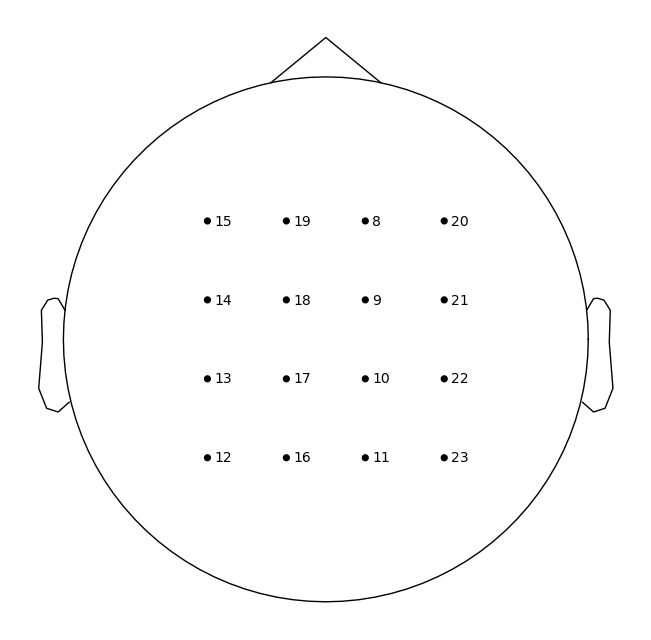

In [8]:
# Create montage (coord_frame='unknown' for non-human data)
montage = mne.channels.make_dig_montage(ch_pos=ch_pos, coord_frame="unknown")

# Visualize the montage
montage.plot(kind="topomap", show=True)

In [9]:
# Plot the 2D coordinates (ML vs AP) in Matplotlib
fig, ax = plt.subplots(figsize=(6, 6))

# Iterate over each channel and plot it
for _, row in df_coords.iterrows():
    ax.scatter(row["ML (mm)"], row["AP (mm)"], color='red', s=100)
    ax.text(row["ML (mm)"], row["AP (mm)"], str(int(row["Channel"])), fontsize=12,
            ha='center', va='center', color='white', bbox=dict(facecolor='black', alpha=0.6))

# Formatting the plot
ax.set_xlabel("Medio-Lateral (ML) Position (mm)")
ax.set_ylabel("Antero-Posterior (AP) Position (mm)")
ax.set_title("Electrode Layout in ML-AP Space")
ax.set_xticks(np.arange(df_coords["ML (mm)"].min() - 0.5, df_coords["ML (mm)"].max() + 0.5, spacing))
ax.set_yticks(np.arange(df_coords["AP (mm)"].min() - 0.5, df_coords["AP (mm)"].max() + 0.5, spacing))
ax.grid(True, linestyle='--', alpha=0.7)
plt.gca()  # AP coordinates usually decrease in the posterior direction

# Show plot
plt.savefig("Electrode_Layout.png")

<IPython.core.display.Javascript object>

In [10]:
recording_notes = pd.read_csv('./data/recording_notes.csv')

In [11]:
# Function to convert MM:SS to seconds
def mmss_to_seconds(value):
    if ':' in value:
        minutes, seconds = map(int, value.split(':'))
        return minutes * 60 + seconds
    return int(value)  # If the value is already in seconds

# Function to extract tuples and handle MM:SS conversion
def extract_tuples(cell):
    try:
        if isinstance(cell, str):
            # Match all ranges in the format "start-end stim" with optional MM:SS format
            matches = re.findall(r"([\d:]+)-([\d:]+)", cell)
            # Convert matches to tuples of integers in seconds
            return [(mmss_to_seconds(start), mmss_to_seconds(end)) for start, end in matches]
        else:
            return np.nan  # Return NaN if cell is not a string
    except:
        return np.nan  # Return NaN if any error occurs


In [12]:
recording_notes

,# of Test,Duration,Action,Stimulation time window in seconds
0,2,60s,Silence; Software AVG as ref 002,NaN
1,3,60s,Silence; AVG ref 003,NaN
2,4,60s,Whisker: 2 sides air pump blowing 004 (5s wait),20-26 30-36 40-45 50-55 60-65
3,5,60s,Silence avg ref 005,NaN
4,6,60s,Whisker 2 sides tweezers stirring 006 (5s wait),15-19 25-30 35-41 46-50
5,7,60s,Silence 007,NaN
6,8,60s,Foot pinch both 008 (5s wait),10-15 21-26 31-36 41-45 51-56 60-65
7,9,60s,Silence 009,NaN
8,10,60s,Whisker: 2 sides air pump blowing 010 (30s wait),10-16 31-35 42-45 75-80
9,11,60s,Silence 011,NaN


In [13]:
# Apply the function to the column
recording_notes["Stimulation Tuples"] = recording_notes["Stimulation time window in seconds"].apply(extract_tuples)

In [14]:
recording_notes

,# of Test,Duration,Action,Stimulation time window in seconds,Stimulation Tuples
0,2,60s,Silence; Software AVG as ref 002,NaN,NaN
1,3,60s,Silence; AVG ref 003,NaN,NaN
2,4,60s,Whisker: 2 sides air pump blowing 004 (5s wait),20-26 30-36 40-45 50-55 60-65,"[(20, 26), (30, 36), (40, 45), (50, 55), (60, ..."
3,5,60s,Silence avg ref 005,NaN,NaN
4,6,60s,Whisker 2 sides tweezers stirring 006 (5s wait),15-19 25-30 35-41 46-50,"[(15, 19), (25, 30), (35, 41), (46, 50)]"
5,7,60s,Silence 007,NaN,NaN
6,8,60s,Foot pinch both 008 (5s wait),10-15 21-26 31-36 41-45 51-56 60-65,"[(10, 15), (21, 26), (31, 36), (41, 45), (51, ..."
7,9,60s,Silence 009,NaN,NaN
8,10,60s,Whisker: 2 sides air pump blowing 010 (30s wait),10-16 31-35 42-45 75-80,"[(10, 16), (31, 35), (42, 45), (75, 80)]"
9,11,60s,Silence 011,NaN,NaN


In [15]:
eeg_files = sorted(glob.glob('./data/0211_MEA_2025_02_17/**/*.rhd', recursive=True))

In [16]:
eeg_files

['./data/0211_MEA_2025_02_17/001_250211_172552/001_250211_172552.rhd',
 './data/0211_MEA_2025_02_17/001_250211_172552/001_250211_172652.rhd',
 './data/0211_MEA_2025_02_17/002_250211_172819/002_250211_172819.rhd',
 './data/0211_MEA_2025_02_17/002_250211_172819/002_250211_172919.rhd',
 './data/0211_MEA_2025_02_17/003_250211_173248/003_250211_173248.rhd',
 './data/0211_MEA_2025_02_17/003_250211_173248/003_250211_173348.rhd',
 './data/0211_MEA_2025_02_17/004_250211_173432/004_250211_173432.rhd',
 './data/0211_MEA_2025_02_17/004_250211_173432/004_250211_173533.rhd',
 './data/0211_MEA_2025_02_17/005_250211_173615/005_250211_173615.rhd',
 './data/0211_MEA_2025_02_17/005_250211_173615/005_250211_173715.rhd',
 './data/0211_MEA_2025_02_17/006_250211_173835/006_250211_173835.rhd',
 './data/0211_MEA_2025_02_17/006_250211_173835/006_250211_173935.rhd',
 './data/0211_MEA_2025_02_17/007_250211_174025/007_250211_174025.rhd',
 './data/0211_MEA_2025_02_17/007_250211_174025/007_250211_174126.rhd',
 './da

- Loading in the data

In [17]:
from mne.time_frequency import tfr_morlet

In [18]:
recording_notes

,# of Test,Duration,Action,Stimulation time window in seconds,Stimulation Tuples
0,2,60s,Silence; Software AVG as ref 002,NaN,NaN
1,3,60s,Silence; AVG ref 003,NaN,NaN
2,4,60s,Whisker: 2 sides air pump blowing 004 (5s wait),20-26 30-36 40-45 50-55 60-65,"[(20, 26), (30, 36), (40, 45), (50, 55), (60, ..."
3,5,60s,Silence avg ref 005,NaN,NaN
4,6,60s,Whisker 2 sides tweezers stirring 006 (5s wait),15-19 25-30 35-41 46-50,"[(15, 19), (25, 30), (35, 41), (46, 50)]"
5,7,60s,Silence 007,NaN,NaN
6,8,60s,Foot pinch both 008 (5s wait),10-15 21-26 31-36 41-45 51-56 60-65,"[(10, 15), (21, 26), (31, 36), (41, 45), (51, ..."
7,9,60s,Silence 009,NaN,NaN
8,10,60s,Whisker: 2 sides air pump blowing 010 (30s wait),10-16 31-35 42-45 75-80,"[(10, 16), (31, 35), (42, 45), (75, 80)]"
9,11,60s,Silence 011,NaN,NaN


In [19]:

from collections import defaultdict
import os
import matplotlib.pyplot as plt
import mne
from mne.time_frequency import tfr_morlet
import numpy as np
from mne.time_frequency import tfr_array_morlet
from mne.time_frequency import tfr_array_multitaper
from mne.time_frequency import tfr_multitaper

In [20]:
# Create subfolders for each plot type
os.makedirs("./plots/freq_filtered_timeseries", exist_ok=True)
os.makedirs("./plots/freq_filtered_psd", exist_ok=True)
os.makedirs("./plots/ica_components", exist_ok=True)
os.makedirs("./plots/ica_filtered_timeseries", exist_ok=True)
os.makedirs("./plots/ica_filtered_psd", exist_ok=True)
os.makedirs("./plots/tfr_wavelet", exist_ok=True)

In [21]:
TIME_HALFBANDWIDTH_PRODUCT = 2
TIME_WINDOW_DURATION = 1
TIME_WINDOW_STEP = 0.5
RESAMPLE_RATE=1000

In [ ]:
# Re-import necessary libraries after execution state reset
import os
import numpy as np
import pandas as pd
import mne

initial_offset = 5

# Initialize a list to store DataFrame rows
eeg_data_records = []

# Processing each file
for file_path in eeg_files[1:]:  # or eeg_files[5:] depending on your choice
    file_base = os.path.splitext(os.path.basename(file_path))[0]

    try:
        # Extract numeric recording number from file name (e.g., "006_250121_175954" → 6)
        recording_number = int(file_base.split('_')[0])

        # Find the matching row in the DataFrame
        row = recording_notes[recording_notes["# of Test"] == recording_number]

        if row.empty:
            print(f"No stimulation data for recording {recording_number}")
            stimulation_times = None
        else:
            # Extract tuple list
            stimulation_times = row["Stimulation Tuples"].values[0]

        result, data_present = load_file(file_path)

        # Extract channel names and sample rate
        all_channels = [
            d["native_channel_name"].replace("A-0", "")
            for d in result["amplifier_channels"]
        ]
        sampling_rate = result["frequency_parameters"]["amplifier_sample_rate"]

        # Find indices of valid channels
        valid_indices = [i for i, ch in enumerate(all_channels) if str(int(ch)) in ch_pos]
        filtered_data = result["amplifier_data"][valid_indices]
        filtered_channel_list = [str(int(all_channels[i])) for i in valid_indices]

        # Create MNE Info and RawArray
        info = mne.create_info(
            ch_names=filtered_channel_list,
            sfreq=sampling_rate,
            ch_types='eeg'
        )
        raw = mne.io.RawArray(filtered_data, info)

        # Crop the first and last 5 seconds
        duration = raw.times[-1]  # Total duration of the recording
        if duration > 30:  # Ensure at least 10 seconds remain after cropping
            raw.crop(tmin=initial_offset, tmax=duration - 10)
        else:
            print(f"File {file_base} too short after cropping.")
            continue

        # Apply montage
        raw.set_montage(montage)

        # Preprocessing: Filter and downsample
        raw.notch_filter(60)  # Notch filter at 60 Hz
        raw.filter(l_freq=1.0, h_freq=30.0)
        raw.resample(250, npad='auto')

        # -----------------------------------------------------------
        # 3) ICA Artifact Removal + ICA Components Plot
        # -----------------------------------------------------------
        ica = mne.preprocessing.ICA(n_components=10, method='fastica', random_state=42)
        ica.fit(raw)
        ica.exclude = []  # Exclude identified artifact components
        raw_ica = ica.apply(raw.copy())

        fig_ica = ica.plot_components(show=False)
        fig_ica.savefig(f"./plots/ica_components/{file_base}.png", dpi=300)

        # Extract data and time points for plotting
        data = raw.get_data()  # Shape: (n_channels, n_times)
        times = raw.times  # Time points in seconds

        # Store each channel's EEG trace in a DataFrame row
        for i, channel in enumerate(filtered_channel_list):
            eeg_data_records.append({
                "Recording Name": file_base,
                "Channel": channel,
                "Filtered EEG Trace": np.array(data[i]),  # Store trace as a list
                "Sampling Rate": sampling_rate,
                "Stimulation Times": stimulation_times,
                "Recording Notes": row["Action"].values[0],
                "Time Points": times
                
            })

    except Exception as e:
        print(f"Error processing {file_base}: {e}")
        break
        continue

# Convert to DataFrame
eeg_df = pd.DataFrame(eeg_data_records)




No stimulation data for recording 1

Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 1.054 seconds of data.  Amplifiers were sampled at 30.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 0.0 seconds
Creating RawArray with float64 data, n_channels=16, n_times=31616
    Range : 0 ... 31615 =      0.000 ...     1.054 secs
Ready.
File 001_250211_172652 too short after cropping.

Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board AD

/tmp/ipykernel_89363/887478446.py:61: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 99001 samples (3.300 s)

Fitting ICA to data using 16 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 1.2s.
Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 0 ICA components
    Projecting back using 16 PCA components


/home/riwata/Documents/projects/NIT_Lab/bin/conda/mne/lib/python3.13/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


<IPython.core.display.Javascript object>


Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 0.644 seconds of data.  Amplifiers were sampled at 30.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 0.0 seconds
Creating RawArray with float64 data, n_channels=16, n_times=19328
    Range : 0 ... 19327 =      0.000 ...     0.644 secs
Ready.
File 002_250211_172919 too short after cropping.

Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital in

/tmp/ipykernel_89363/887478446.py:61: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 99001 samples (3.300 s)

Fitting ICA to data using 16 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 1.0s.
Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 0 ICA components
    Projecting back using 16 PCA components


/home/riwata/Documents/projects/NIT_Lab/bin/conda/mne/lib/python3.13/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


<IPython.core.display.Javascript object>


Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 22.353 seconds of data.  Amplifiers were sampled at 30.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 0.2 seconds
Creating RawArray with float64 data, n_channels=16, n_times=670592
    Range : 0 ... 670591 =      0.000 ...    22.353 secs
Ready.
File 003_250211_173348 too short after cropping.

Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital

/tmp/ipykernel_89363/887478446.py:61: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 99001 samples (3.300 s)

Fitting ICA to data using 16 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 1.1s.
Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 0 ICA components
    Projecting back using 16 PCA components


/home/riwata/Documents/projects/NIT_Lab/bin/conda/mne/lib/python3.13/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


<IPython.core.display.Javascript object>


Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 22.933 seconds of data.  Amplifiers were sampled at 30.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 0.2 seconds
Creating RawArray with float64 data, n_channels=16, n_times=688000
    Range : 0 ... 687999 =      0.000 ...    22.933 secs
Ready.
File 004_250211_173533 too short after cropping.

Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital

/tmp/ipykernel_89363/887478446.py:61: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 99001 samples (3.300 s)

Fitting ICA to data using 16 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 1.1s.
Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 0 ICA components
    Projecting back using 16 PCA components


/home/riwata/Documents/projects/NIT_Lab/bin/conda/mne/lib/python3.13/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


<IPython.core.display.Javascript object>


Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 15.049 seconds of data.  Amplifiers were sampled at 30.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 0.1 seconds
Creating RawArray with float64 data, n_channels=16, n_times=451456
    Range : 0 ... 451455 =      0.000 ...    15.049 secs
Ready.
File 005_250211_173715 too short after cropping.

Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital

/tmp/ipykernel_89363/887478446.py:61: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 99001 samples (3.300 s)

Fitting ICA to data using 16 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 0.1s.
Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 0 ICA components
    Projecting back using 16 PCA components


<IPython.core.display.Javascript object>


Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 18.940 seconds of data.  Amplifiers were sampled at 30.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 0.1 seconds
Creating RawArray with float64 data, n_channels=16, n_times=568192
    Range : 0 ... 568191 =      0.000 ...    18.940 secs
Ready.
File 006_250211_173935 too short after cropping.

Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital

/tmp/ipykernel_89363/887478446.py:61: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 99001 samples (3.300 s)

Fitting ICA to data using 16 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 1.2s.
Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 0 ICA components
    Projecting back using 16 PCA components


/home/riwata/Documents/projects/NIT_Lab/bin/conda/mne/lib/python3.13/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


<IPython.core.display.Javascript object>


Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 0.508 seconds of data.  Amplifiers were sampled at 30.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 0.0 seconds
Creating RawArray with float64 data, n_channels=16, n_times=15232
    Range : 0 ... 15231 =      0.000 ...     0.508 secs
Ready.
File 007_250211_174126 too short after cropping.

Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital in

/tmp/ipykernel_89363/887478446.py:61: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 99001 samples (3.300 s)

Fitting ICA to data using 16 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 0.1s.
Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 0 ICA components
    Projecting back using 16 PCA components


<IPython.core.display.Javascript object>


Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 14.298 seconds of data.  Amplifiers were sampled at 30.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 0.1 seconds
Creating RawArray with float64 data, n_channels=16, n_times=428928
    Range : 0 ... 428927 =      0.000 ...    14.298 secs
Ready.
File 008_250211_174339 too short after cropping.

Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital

/tmp/ipykernel_89363/887478446.py:61: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 99001 samples (3.300 s)

Fitting ICA to data using 16 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 1.2s.
Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 0 ICA components
    Projecting back using 16 PCA components


<IPython.core.display.Javascript object>


Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 17.813 seconds of data.  Amplifiers were sampled at 30.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 0.1 seconds
Creating RawArray with float64 data, n_channels=16, n_times=534400
    Range : 0 ... 534399 =      0.000 ...    17.813 secs
Ready.
File 009_250211_174550 too short after cropping.

Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital

/tmp/ipykernel_89363/887478446.py:61: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 99001 samples (3.300 s)

Fitting ICA to data using 16 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 1.1s.
Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 0 ICA components
    Projecting back using 16 PCA components


/home/riwata/Documents/projects/NIT_Lab/bin/conda/mne/lib/python3.13/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


<IPython.core.display.Javascript object>


Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 60.002 seconds of data.  Amplifiers were sampled at 30.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 0.7 seconds
Creating RawArray with float64 data, n_channels=16, n_times=1800064
    Range : 0 ... 1800063 =      0.000 ...    60.002 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hammin

/tmp/ipykernel_89363/887478446.py:61: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 99001 samples (3.300 s)

Fitting ICA to data using 16 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 0.1s.
Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 0 ICA components
    Projecting back using 16 PCA components


<IPython.core.display.Javascript object>


Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 4.779 seconds of data.  Amplifiers were sampled at 30.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 0.0 seconds
Creating RawArray with float64 data, n_channels=16, n_times=143360
    Range : 0 ... 143359 =      0.000 ...     4.779 secs
Ready.
File 010_250211_174847 too short after cropping.

Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital 

/tmp/ipykernel_89363/887478446.py:61: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 99001 samples (3.300 s)

Fitting ICA to data using 16 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 0 ICA components
    Projecting back using 16 PCA components


<IPython.core.display.Javascript object>


Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 10.133 seconds of data.  Amplifiers were sampled at 30.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 0.1 seconds
Creating RawArray with float64 data, n_channels=16, n_times=304000
    Range : 0 ... 303999 =      0.000 ...    10.133 secs
Ready.
File 011_250211_175011 too short after cropping.

Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital

/tmp/ipykernel_89363/887478446.py:61: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 99001 samples (3.300 s)

Fitting ICA to data using 16 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 0.1s.
Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 0 ICA components
    Projecting back using 16 PCA components


<IPython.core.display.Javascript object>


Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 25.289 seconds of data.  Amplifiers were sampled at 30.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 0.2 seconds
Creating RawArray with float64 data, n_channels=16, n_times=758656
    Range : 0 ... 758655 =      0.000 ...    25.288 secs
Ready.
File 012_250211_175213 too short after cropping.

Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital

/tmp/ipykernel_89363/887478446.py:61: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 99001 samples (3.300 s)

Fitting ICA to data using 16 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 1.0s.
Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 0 ICA components
    Projecting back using 16 PCA components


/home/riwata/Documents/projects/NIT_Lab/bin/conda/mne/lib/python3.13/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


<IPython.core.display.Javascript object>


Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 12.250 seconds of data.  Amplifiers were sampled at 30.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 0.1 seconds
Creating RawArray with float64 data, n_channels=16, n_times=367488
    Range : 0 ... 367487 =      0.000 ...    12.250 secs
Ready.
File 013_250211_175350 too short after cropping.

Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital

/tmp/ipykernel_89363/887478446.py:61: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 99001 samples (3.300 s)

Fitting ICA to data using 16 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 0 ICA components
    Projecting back using 16 PCA components


<IPython.core.display.Javascript object>


Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 2.624 seconds of data.  Amplifiers were sampled at 30.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 0.0 seconds
Creating RawArray with float64 data, n_channels=16, n_times=78720
    Range : 0 ... 78719 =      0.000 ...     2.624 secs
Ready.
File 014_250211_175553 too short after cropping.

Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital in

/tmp/ipykernel_89363/887478446.py:61: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 99001 samples (3.300 s)

Fitting ICA to data using 16 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 0.1s.
Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 0 ICA components
    Projecting back using 16 PCA components


<IPython.core.display.Javascript object>


Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 0.781 seconds of data.  Amplifiers were sampled at 30.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 0.0 seconds
Creating RawArray with float64 data, n_channels=16, n_times=23424
    Range : 0 ... 23423 =      0.000 ...     0.781 secs
Ready.
File 015_250211_175709 too short after cropping.

Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital in

/tmp/ipykernel_89363/887478446.py:61: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 99001 samples (3.300 s)

Fitting ICA to data using 16 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 1.1s.
Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 0 ICA components
    Projecting back using 16 PCA components


/home/riwata/Documents/projects/NIT_Lab/bin/conda/mne/lib/python3.13/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


<IPython.core.display.Javascript object>


Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 4.774 seconds of data.  Amplifiers were sampled at 30.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 0.0 seconds
Creating RawArray with float64 data, n_channels=16, n_times=143232
    Range : 0 ... 143231 =      0.000 ...     4.774 secs
Ready.
File 016_250211_175829 too short after cropping.

Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital 

/tmp/ipykernel_89363/887478446.py:61: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 99001 samples (3.300 s)

Fitting ICA to data using 16 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 0.1s.
Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 0 ICA components
    Projecting back using 16 PCA components


<IPython.core.display.Javascript object>


Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 3.921 seconds of data.  Amplifiers were sampled at 30.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 0.0 seconds
Creating RawArray with float64 data, n_channels=16, n_times=117632
    Range : 0 ... 117631 =      0.000 ...     3.921 secs
Ready.
File 017_250211_180048 too short after cropping.

Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital 

/tmp/ipykernel_89363/887478446.py:61: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 99001 samples (3.300 s)

Fitting ICA to data using 16 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 1.3s.
Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 0 ICA components
    Projecting back using 16 PCA components


/home/riwata/Documents/projects/NIT_Lab/bin/conda/mne/lib/python3.13/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


<IPython.core.display.Javascript object>


Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 17.882 seconds of data.  Amplifiers were sampled at 30.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 0.1 seconds
Creating RawArray with float64 data, n_channels=16, n_times=536448
    Range : 0 ... 536447 =      0.000 ...    17.882 secs
Ready.
File 018_250211_180734 too short after cropping.

Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital

/tmp/ipykernel_89363/887478446.py:61: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 99001 samples (3.300 s)

Fitting ICA to data using 16 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 0.1s.
Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 0 ICA components
    Projecting back using 16 PCA components


<IPython.core.display.Javascript object>


Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 0.201 seconds of data.  Amplifiers were sampled at 30.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 0.0 seconds
Creating RawArray with float64 data, n_channels=16, n_times=6016
    Range : 0 ... 6015 =      0.000 ...     0.201 secs
Ready.
File 019_250211_181021 too short after cropping.

Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital inpu

/tmp/ipykernel_89363/887478446.py:61: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 99001 samples (3.300 s)

Fitting ICA to data using 16 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 1.0s.
Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 0 ICA components
    Projecting back using 16 PCA components


/home/riwata/Documents/projects/NIT_Lab/bin/conda/mne/lib/python3.13/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


<IPython.core.display.Javascript object>


Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 29.419 seconds of data.  Amplifiers were sampled at 30.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 0.2 seconds
Creating RawArray with float64 data, n_channels=16, n_times=882560
    Range : 0 ... 882559 =      0.000 ...    29.419 secs
Ready.
File 020_250211_181224 too short after cropping.

Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital

/tmp/ipykernel_89363/887478446.py:61: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 99001 samples (3.300 s)

Fitting ICA to data using 16 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 1.2s.
Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 0 ICA components
    Projecting back using 16 PCA components


/home/riwata/Documents/projects/NIT_Lab/bin/conda/mne/lib/python3.13/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/riwata/Documents/projects/NIT_Lab/bin/conda/mne/lib/python3.13/site-packages/mne/viz/_mpl_figure.py:2355: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(FigureClass=FigureClass, **kwargs)


<IPython.core.display.Javascript object>


Reading Intan Technologies RHD Data File, Version 3.3

Found 16 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 32.695 seconds of data.  Amplifiers were sampled at 30.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 0.3 seconds
Creating RawArray with float64 data, n_channels=16, n_times=980864
    Range : 0 ... 980863 =      0.000 ...    32.695 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming 

/tmp/ipykernel_89363/887478446.py:61: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 99001 samples (3.300 s)

Fitting ICA to data using 16 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 0 ICA components
    Projecting back using 16 PCA components


/home/riwata/Documents/projects/NIT_Lab/bin/conda/mne/lib/python3.13/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


<IPython.core.display.Javascript object>

In [23]:
raise ValueError()

ValueError: 

In [25]:
eeg_df.head()

,Recording Name,Channel,Filtered EEG Trace,Sampling Rate,Stimulation Times,Recording Notes
0,002_250211_172819,8,"[3.761857762750537, 24.10007722596199, 42.3997...",30000.0,NaN,Silence; Software AVG as ref 002
1,002_250211_172819,9,"[7.843839650941483, 49.27198598191334, 82.5559...",30000.0,NaN,Silence; Software AVG as ref 002
2,002_250211_172819,10,"[0.18485057642473685, 2.1933781635768113, 7.76...",30000.0,NaN,Silence; Software AVG as ref 002
3,002_250211_172819,11,"[3.0232428164126968, 19.121879143194153, 32.49...",30000.0,NaN,Silence; Software AVG as ref 002
4,002_250211_172819,12,"[2.6935757466398487, 17.472491264996737, 31.46...",30000.0,NaN,Silence; Software AVG as ref 002


In [29]:
from scipy import stats


In [ ]:
eeg_df["MAD EEG Trace"] = eeg_df["Filtered EEG Trace"].apply(lambda x: stats.median_abs_deviation(x))

In [32]:
eeg_df["Modified Z-score EEG"] = eeg_df.apply(lambda x: 0.6745 * (x["Filtered EEG Trace"] - np.median(x["Filtered EEG Trace"])) / x["MAD EEG Trace"], axis=1)

In [47]:
zscore_threshold = 4

In [48]:
eeg_df["Mask EEG"] = eeg_df["Modified Z-score EEG"].apply(lambda x: np.abs(x) >= zscore_threshold)

In [49]:
def update_array_by_mask(array, mask, value=np.nan):
    """
    Update elements of an array specified by a mask with a given value.
    
    Parameters:
        array (np.ndarray): The original array to be modified.
        mask (np.ndarray): A boolean array of the same shape as `array`.
                           Elements of `array` corresponding to True in the `mask`
                           will be updated.
        value (scalar, optional): The value to assign to elements of `array` specified by `mask`.
                                  Default is np.nan.
    
    Returns:
        np.ndarray: A copy of `array` with the specified elements updated.
    """
    result = array.copy()  # Create a copy of the input array to modify
    result[mask] = value   # Apply the mask to update the designated elements
    return result

In [56]:
eeg_df["Mask EEG"][1][:50]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [50]:
eeg_df["Z score filtered EEG"] = eeg_df.apply(lambda x: update_array_by_mask(x["Filtered EEG Trace"], x["Mask EEG"]), axis=1)

In [62]:
eeg_df["RMS EEG"] = eeg_df["Z score filtered EEG"].apply(lambda x: (x / np.sqrt(np.nanmean(x**2))).astype(np.float32))

In [66]:
eeg_df["RMS EEG"]

0      [0.16146319, 1.0344025, 1.8198435, 2.4544876, ...
1      [0.24244794, 1.5229648, 2.55175, 3.1671886, 3....
2      [0.0064767934, 0.07685157, 0.2721964, 0.604302...
3      [0.11111659, 0.7028076, 1.1943707, 1.5136544, ...
4      [0.060288157, 0.39107284, 0.70431113, 0.964782...
                             ...                        
347    [0.14435147, -1.2573414, -2.411737, -3.1239467...
348    [-0.010426073, 0.09998538, 0.25422063, 0.45963...
349    [-0.0613586, 0.5336834, 1.022741, 1.34119, 1.5...
350    [0.034793075, -0.30271816, -0.58612233, -0.782...
351    [0.03877865, -0.34456483, -0.7058415, -1.01945...
Name: RMS EEG, Length: 352, dtype: object

In [55]:
eeg_df["Filtered EEG Trace"][1][:50]

array([  7.84383965,  49.27198598,  82.55594175, 102.46702655,
       106.6577038 ,  96.4333264 ,  76.68022664,  54.6007525 ,
        37.52244688,  30.45430311,  34.48619786,  46.77740972,
        62.23634979,  76.06022823,  85.84211436,  92.17672527,
        97.47153387, 103.76802454, 110.81758757, 115.64002465,
       113.8722703 , 102.21281449,  80.54137093,  52.53369938,
        24.36170244,   2.12184895, -10.70206847, -14.39837925,
       -12.37240508,  -9.11461555,  -7.88775402,  -9.32585892,
       -11.52172677, -11.36960991,  -6.35557108,   4.16869409,
        18.78503796,  34.65381346,  48.68695277,  58.43431355,
        62.52812819,  60.632401  ,  53.25352361,  41.53525318,
        27.20565832,  12.39481114,  -0.63873147,  -9.98616277,
       -14.54960392, -14.27266117])

In [52]:
eeg_df["Z score filtered EEG"][1][:10]

array([  7.84383965,  49.27198598,  82.55594175, 102.46702655,
       106.6577038 ,  96.4333264 ,  76.68022664,  54.6007525 ,
        37.52244688,  30.45430311])

In [57]:
eeg_df["Modified Z-score EEG"][1][:50]

array([ 0.24848401,  1.57836782,  2.64681518,  3.28598037,  3.42050519,
        3.09229273,  2.45819901,  1.74942641,  1.20119618,  0.97430189,
        1.10372963,  1.49828949,  1.99453651,  2.43829645,  2.75230452,
        2.95565169,  3.1256202 ,  3.32774367,  3.5540415 ,  3.70884643,
        3.65209979,  3.27781992,  2.5821455 ,  1.68307199,  0.77872348,
        0.06480255, -0.34685768, -0.46551285, -0.40047711, -0.2958989 ,
       -0.25651545, -0.30268001, -0.37316951, -0.36828641, -0.20733089,
        0.13050827,  0.59970712,  1.10911026,  1.55958768,  1.87248745,
        2.00390288,  1.94304819,  1.70617905,  1.33001117,  0.87001723,
        0.39457463, -0.02381477, -0.32387641, -0.47036731, -0.46147718])

In [38]:
eeg_df["Mask EEG"]

0      [False, False, False, False, False, True, True...
1      [False, False, False, True, True, True, False,...
2      [False, False, False, False, False, False, Fal...
3      [False, False, False, False, False, False, Fal...
4      [False, False, False, False, False, False, Fal...
                             ...                        
347    [False, False, False, True, True, True, False,...
348    [False, False, False, False, False, False, Fal...
349    [False, False, False, False, False, False, Fal...
350    [False, False, False, False, False, False, Fal...
351    [False, False, False, False, False, False, Fal...
Name: Mask EEG, Length: 352, dtype: object

In [59]:
eeg_df.head()

,Recording Name,Channel,Filtered EEG Trace,Sampling Rate,Stimulation Times,Recording Notes,MAD EEG Trace,Modified Z-score EEG,RMS EEG,Mask EEG,Z score filtered EEG
0,002_250211_172819,8,"[3.761857762750537, 24.10007722596199, 42.3997...",30000.0,NaN,Silence; Software AVG as ref 002,15.459769,"[0.16976552413387114, 1.0571092395538428, 1.85...","[0.15930974, 1.0206068, 1.7955723, 2.421752, 2...","[False, False, False, False, False, False, Fal...","[3.761857762750537, 24.10007722596199, 42.3997..."
1,002_250211_172819,9,"[7.843839650941483, 49.27198598191334, 82.5559...",30000.0,NaN,Silence; Software AVG as ref 002,21.011824,"[0.24848401352773297, 1.5783678162249575, 2.64...","[0.24206616, 1.5205666, 2.5477319, 3.1622012, ...","[False, False, False, False, False, False, Fal...","[7.843839650941483, 49.27198598191334, 82.5559..."
2,002_250211_172819,10,"[0.18485057642473685, 2.1933781635768113, 7.76...",30000.0,NaN,Silence; Software AVG as ref 002,19.569317,"[-0.024099544251345046, 0.04512882167694321, 0...","[0.006466483, 0.07672924, 0.27176312, 0.603340...","[False, False, False, False, False, False, Fal...","[0.18485057642473685, 2.1933781635768113, 7.76..."
3,002_250211_172819,11,"[3.0232428164126968, 19.121879143194153, 32.49...",30000.0,NaN,Silence; Software AVG as ref 002,18.129930,"[0.06610678469115076, 0.6650352090754911, 1.16...","[0.11111659, 0.7028076, 1.1943707, 1.5136544, ...","[False, False, False, False, False, False, Fal...","[3.0232428164126968, 19.121879143194153, 32.49..."
4,002_250211_172819,12,"[2.6935757466398487, 17.472491264996737, 31.46...",30000.0,NaN,Silence; Software AVG as ref 002,27.214824,"[0.004359200204763748, 0.3706440820933973, 0.7...","[0.05829138, 0.37812027, 0.68098396, 0.9328279...","[False, False, False, False, False, False, Fal...","[2.6935757466398487, 17.472491264996737, 31.46..."


In [35]:
eeg_df["RMS EEG"] = eeg_df["Filtered EEG Trace"].apply(lambda x: (x / np.sqrt(np.mean(x**2))).astype(np.float32))

In [33]:
eeg_df["Modified Z-score EEG"]

0      [0.16976552413387114, 1.0571092395538428, 1.85...
1      [0.24848401352773297, 1.5783678162249575, 2.64...
2      [-0.024099544251345046, 0.04512882167694321, 0...
3      [0.06610678469115076, 0.6650352090754911, 1.16...
4      [0.004359200204763748, 0.3706440820933973, 0.7...
                             ...                        
347    [0.15305784679623746, -1.2678546280797478, -2....
348    [-0.04123528908822296, 0.06992887835091019, 0....
349    [-0.20850548300565744, 0.4522293440999754, 0.9...
350    [0.05294231510992587, -0.27431553655347846, -0...
351    [0.0370994832275399, -0.3389541106885941, -0.6...
Name: Modified Z-score EEG, Length: 352, dtype: object

In [31]:
eeg_df["MAD EEG Trace"]

0       15.459769
1       21.011824
2       19.569317
3       18.129930
4       27.214824
          ...    
347     32.310575
348     28.572206
349    104.021879
350     26.260201
351     23.353383
Name: MAD EEG Trace, Length: 352, dtype: float64

In [26]:
eeg_df["Filtered EEG Trace"][0]

array([  3.76185776,  24.10007723,  42.39971177, ..., -80.49975975,
       -51.90171366,  -8.19145789], shape=(11251,))

In [67]:
# Update the code to work with the new dataframe (eeg_df)

# Define required constants for Multitaper analysis
RESAMPLE_RATE = 250  # Adjust based on preprocessing
TIME_HALFBANDWIDTH_PRODUCT = 2
TIME_WINDOW_DURATION = 1.0  # 1 second windows
TIME_WINDOW_STEP = 0.5  # 0.5 second step
FILTER_BAND = (1, 30)  # Frequency band of interest

In [87]:


# Initialize storage for results
index_to_multitaper = {}
index_to_connectivity = {}
index_to_frequencies = {}
index_to_power = {}

# Process each channel in the dataframe
for index, row in eeg_df.iterrows():
    print(f"Processing {row["Channel"]} for recording {row['Recording Name']}")

    try:
        # Apply Multitaper function to the filtered EEG trace
        index_to_multitaper[index] = Multitaper(
            time_series=row["RMS EEG"], 
            sampling_frequency=250, 
            time_halfbandwidth_product=TIME_HALFBANDWIDTH_PRODUCT,
            time_window_duration=TIME_WINDOW_DURATION, 
            time_window_step=TIME_WINDOW_STEP
        )

        index_to_connectivity[index] = Connectivity.from_multitaper(index_to_multitaper[index])
        index_to_frequencies[index] = index_to_connectivity[index].frequencies[FILTER_BAND[0]: FILTER_BAND[1]]
        index_to_power[index] = index_to_connectivity[index].power().squeeze()[:, FILTER_BAND[0]: FILTER_BAND[1]]

    except Exception as e:
        print(f"Error processing: {e}")
        continue

# Store results in the dataframe
eeg_df["Power Frequencies"] = eeg_df.index.to_series().map(index_to_frequencies)
eeg_df["Power Values"] = eeg_df.index.to_series().map(index_to_power)
eeg_df["Power Values"] = eeg_df["Power Values"].apply(lambda x: x.astype(np.float32) if isinstance(x, np.ndarray) else np.nan)


Processing 8 for recording 002_250211_172819
Processing 9 for recording 002_250211_172819
Processing 10 for recording 002_250211_172819
Processing 11 for recording 002_250211_172819
Processing 12 for recording 002_250211_172819
Processing 13 for recording 002_250211_172819
Processing 14 for recording 002_250211_172819
Processing 15 for recording 002_250211_172819
Processing 16 for recording 002_250211_172819
Processing 17 for recording 002_250211_172819
Processing 18 for recording 002_250211_172819
Processing 19 for recording 002_250211_172819
Processing 20 for recording 002_250211_172819
Processing 21 for recording 002_250211_172819
Processing 22 for recording 002_250211_172819
Processing 23 for recording 002_250211_172819
Processing 8 for recording 003_250211_173248
Processing 9 for recording 003_250211_173248
Processing 10 for recording 003_250211_173248
Processing 11 for recording 003_250211_173248
Processing 12 for recording 003_250211_173248
Processing 13 for recording 003_250211

In [88]:
eeg_df

,Recording Name,Channel,Filtered EEG Trace,Sampling Rate,Stimulation Times,Recording Notes,MAD EEG Trace,Modified Z-score EEG,RMS EEG,Mask EEG,Z score filtered EEG,Power Frequencies,Power Values
0,002_250211_172819,8,"[3.761857762750537, 24.10007722596199, 42.3997...",30000.0,NaN,Silence; Software AVG as ref 002,15.459769,"[0.16976552413387114, 1.0571092395538428, 1.85...","[0.16146319, 1.0344025, 1.8198435, 2.4544876, ...","[False, False, False, False, False, False, Fal...","[3.761857762750537, 24.10007722596199, 42.3997...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
1,002_250211_172819,9,"[7.843839650941483, 49.27198598191334, 82.5559...",30000.0,NaN,Silence; Software AVG as ref 002,21.011824,"[0.24848401352773297, 1.5783678162249575, 2.64...","[0.24244794, 1.5229648, 2.55175, 3.1671886, 3....","[False, False, False, False, False, False, Fal...","[7.843839650941483, 49.27198598191334, 82.5559...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[[0.024203494, 0.01763905, 0.053108864, 0.0509..."
2,002_250211_172819,10,"[0.18485057642473685, 2.1933781635768113, 7.76...",30000.0,NaN,Silence; Software AVG as ref 002,19.569317,"[-0.024099544251345046, 0.04512882167694321, 0...","[0.0064767934, 0.07685157, 0.2721964, 0.604302...","[False, False, False, False, False, False, Fal...","[0.18485057642473685, 2.1933781635768113, 7.76...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[[0.0068737157, 0.008660652, 0.013086149, 0.01..."
3,002_250211_172819,11,"[3.0232428164126968, 19.121879143194153, 32.49...",30000.0,NaN,Silence; Software AVG as ref 002,18.129930,"[0.06610678469115076, 0.6650352090754911, 1.16...","[0.11111659, 0.7028076, 1.1943707, 1.5136544, ...","[False, False, False, False, False, False, Fal...","[3.0232428164126968, 19.121879143194153, 32.49...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[[0.049114596, 0.04579487, 0.009388729, 0.0072..."
4,002_250211_172819,12,"[2.6935757466398487, 17.472491264996737, 31.46...",30000.0,NaN,Silence; Software AVG as ref 002,27.214824,"[0.004359200204763748, 0.3706440820933973, 0.7...","[0.060288157, 0.39107284, 0.70431113, 0.964782...","[False, False, False, False, False, False, Fal...","[2.6935757466398487, 17.472491264996737, 31.46...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[[0.0122573655, 0.010416341, 0.013523207, 0.01..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,021_250211_181554,19,"[7.009683822660861, -61.056289906708784, -117....",30000.0,"[(6, 10), (30, 35), (55, 60)]",Whiskers touching left side by Sofia,32.310575,"[0.15305784679623746, -1.2678546280797478, -2....","[0.14435147, -1.2573414, -2.411737, -3.1239467...","[False, False, False, False, False, False, Fal...","[7.009683822660861, -61.056289906708784, -117....","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[[0.09140223, 0.09987951, 0.036516834, 0.01534..."
348,021_250211_181554,20,"[-0.44466531058842823, 4.264312505551906, 10.8...",30000.0,"[(6, 10), (30, 35), (55, 60)]",Whiskers touching left side by Sofia,28.572206,"[-0.04123528908822296, 0.06992887835091019, 0....","[-0.010426073, 0.09998538, 0.25422063, 0.45963...","[False, False, False, False, False, False, Fal...","[-0.44466531058842823, 4.264312505551906, 10.8...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[[0.13536914, 0.1148314, 0.04721425, 0.0384721..."
349,021_250211_181554,21,"[-10.50745969273421, 91.39154427829868, 175.14...",30000.0,"[(6, 10), (30, 35), (55, 60)]",Whiskers touching left side by Sofia,104.021879,"[-0.20850548300565744, 0.4522293440999754, 0.9...","[-0.0613586, 0.5336834, 1.022741, 1.34119, 1.5...","[False, False, False, False, False, False, Fal...","[-10.50745969273421, 91.39154427829868, 175.14...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[[0.20112695, 0.14807464, 0.04806632, 0.025816..."
350,021_250211_181554,22,"[1.313441539515182, -11.427636421579546, -22.1...",30000.0,"[(6, 10), (30, 35), (55, 6

In [ ]:
index_to_power[index][2]

(29,)

In [ ]:
# Apply Multitaper function to the filtered EEG trace
index_to_multitaper[index] = Multitaper(
    time_series=row["Filtered EEG Trace"], 
    sampling_frequency=row["Sampling Rate"], 
    time_halfbandwidth_product=TIME_HALFBANDWIDTH_PRODUCT,
    time_window_duration=TIME_WINDOW_DURATION, 
    time_window_step=TIME_WINDOW_STEP
)

In [ ]:
row["Filtered EEG Trace"].shape

In [ ]:
index_to_connectivity[index] = Connectivity.from_multitaper(index_to_multitaper[index])
index_to_frequencies[index] = index_to_connectivity[index].frequencies[FILTER_BAND[0]: FILTER_BAND[1]]
index_to_power[index] = index_to_connectivity[index].power().squeeze()[:, FILTER_BAND[0]: FILTER_BAND[1]]

In [ ]:
eeg_df

In [ ]:
eeg_df

In [ ]:
recording_number

In [ ]:
len(eeg_df["EEG Trace"].iloc[0])

In [ ]:
raise ValueError()

In [ ]:
len(filtered_channel_list)

In [ ]:
ch_pos

In [ ]:
filtered_channel_list

In [ ]:
ch_pos

In [ ]:
# import os
# import numpy as np
# import matplotlib.pyplot as plt
# from collections import defaultdict
# import mne
# from mne.time_frequency import tfr_array_morlet

# # Create subfolders for each plot type
# os.makedirs("./plots/freq_filtered_timeseries", exist_ok=True)
# os.makedirs("./plots/freq_filtered_psd", exist_ok=True)
# os.makedirs("./plots/ica_components", exist_ok=True)
# os.makedirs("./plots/ica_filtered_timeseries", exist_ok=True)
# os.makedirs("./plots/ica_filtered_psd", exist_ok=True)
# os.makedirs("./plots/tfr_wavelet", exist_ok=True)

# index_to_data = defaultdict(dict)
# initial_offset = 5  # Initial offset in seconds

# # Processing each file
# for file_path in eeg_files[:]:  # or eeg_files[5:] depending on your choice
#     file_base = os.path.splitext(os.path.basename(file_path))[0]

#     try:
#         # Extract numeric recording number from file name (e.g., "006_250121_175954" → 6)
#         recording_number = int(file_base.split('_')[0])

#         # Find the matching row in the DataFrame
#         row = recording_notes[recording_notes["# of Test"] == recording_number]

#         if row.empty:
#             print(f"No stimulation data for recording {recording_number}")
#             stimulation_times = None
#         else:
#             # Extract tuple list
#             stimulation_times = row["Stimulation Tuples"].values[0]

#         result, data_present = load_file(file_path)

#         # Extract channel names and sample rate
#         all_channels = [
#             d["native_channel_name"].replace("A-0", "")
#             for d in result["amplifier_channels"]
#         ]
#         sampling_rate = result["frequency_parameters"]["amplifier_sample_rate"]

#         # Find indices of valid channels
#         valid_indices = [i for i, ch in enumerate(all_channels) if ch in ch_pos]
#         filtered_data = result["amplifier_data"][valid_indices]
#         filtered_channel_list = [all_channels[i] for i in valid_indices]

#         # Create MNE Info and RawArray
#         info = mne.create_info(
#             ch_names=filtered_channel_list,
#             sfreq=sampling_rate,
#             ch_types='eeg'
#         )
#         raw = mne.io.RawArray(filtered_data, info)

#         # Crop the first and last 5 seconds
#         duration = raw.times[-1]  # Total duration of the recording
#         if duration > 30:  # Ensure at least 10 seconds remain after cropping
#             raw.crop(tmin=initial_offset, tmax=duration - 10)
#         else:
#             print(f"File {file_base} too short after cropping.")
#             continue

#         # Apply montage
#         raw.set_montage(montage)

#         # Preprocessing: Filter and downsample
#         raw.notch_filter(60)  # Notch filter at 60 Hz
#         raw.filter(l_freq=1.0, h_freq=30.0)
#         raw.resample(250, npad='auto')

#         # Extract data and time points for plotting
#         data = raw.get_data()  # Shape: (n_channels, n_times)
#         times = raw.times  # Time points in seconds
#         n_channels = len(filtered_channel_list)

#         # -----------------------------------------------------------
#         # 1) Freq-Filtered Time Series Plot
#         # -----------------------------------------------------------
#         fig, axs = plt.subplots(n_channels, 1, figsize=(16, 2 * n_channels), sharex=True)

#         for i, ax in enumerate(axs):
#             # Plot the channel data
#             ax.plot(
#                 times + initial_offset,
#                 data[i],
#                 label=f"Channel: {filtered_channel_list[i]}",
#                 alpha=0.8
#             )
#             ax.set_ylabel("Amplitude (µV)")
#             ax.legend(loc="upper right")
#             ax.grid(True)

#             # Shade stimulation times if available
#             if stimulation_times is not None and isinstance(stimulation_times, list):
#                 for (start, end) in stimulation_times:
#                     ax.axvspan(start, end, color="orange", alpha=0.3)

#             # Title only on the first subplot
#             if i == 0:
#                 ax.set_title(f"Frequency filtered EEG Time Series - {file_base}")

#             # ---- Set y-limits based on data range ----
#             channel_min = data[i].min()
#             channel_max = data[i].max()
#             # Clamp lower limit at -100 if the min is below -100
#             y_lower = -100 if channel_min < -100 else channel_min
#             # Clamp upper limit at +100 if the max is above 100
#             y_upper = 100 if channel_max > 100 else channel_max
#             ax.set_ylim(y_lower, y_upper)

#         axs[-1].set_xlabel("Time (s)")
#         plt.tight_layout()

#         # Save the time-series plot
#         plt.savefig(f"./plots/freq_filtered_timeseries/{file_base}.png", dpi=300)
#         plt.show()

#         # -----------------------------------------------------------
#         # 2) Freq-Filtered PSD Plot
#         # -----------------------------------------------------------
#         spectrum = raw.compute_psd(fmin=0, fmax=40, method="multitaper")

#         fig_psd = spectrum.plot(picks="data",
                                
#                                 average=False,
#                                 spatial_colors=True,
#                                 amplitude=False)

#         fig_psd.savefig(f"./plots/freq_filtered_psd/{file_base}.png", dpi=300)
        
#         # -----------------------------------------------------------
#         # 3) ICA Artifact Removal + ICA Components Plot
#         # -----------------------------------------------------------
#         ica = mne.preprocessing.ICA(n_components=10, method='fastica', random_state=42)
#         ica.fit(raw)
#         ica.exclude = [0, 1]  # Exclude identified artifact components
#         raw_ica = ica.apply(raw.copy())

#         fig_ica = ica.plot_components(show=False)
#         fig_ica.savefig(f"./plots/ica_components/{file_base}.png", dpi=300)

#         # -----------------------------------------------------------
#         # 4) ICA-Filtered Time Series
#         # -----------------------------------------------------------
#         data = raw.get_data()  # (n_channels, n_times) after ICA
#         times = raw.times
#         fig, axs = plt.subplots(n_channels, 1, figsize=(16, 2 * n_channels), sharex=True)

#         for i, ax in enumerate(axs):
#             # Plot the channel data
#             ax.plot(
#                 times + initial_offset,
#                 data[i],
#                 label=f"Channel: {filtered_channel_list[i]}",
#                 alpha=0.8
#             )
#             ax.set_ylabel("Amplitude (µV)")
#             ax.legend(loc="upper right")
#             ax.grid(True)

#             # Shade stimulation times if available
#             if stimulation_times is not None and isinstance(stimulation_times, list):
#                 for (start, end) in stimulation_times:
#                     ax.axvspan(start, end, color="orange", alpha=0.3)

#             # Title only on the first subplot
#             if i == 0:
#                 ax.set_title(f"ICA filtered EEG Time Series - {file_base}")

#             # ---- Set y-limits based on data range ----
#             channel_min = data[i].min()
#             channel_max = data[i].max()
#             y_lower = -100 if channel_min < -100 else channel_min
#             y_upper = 100 if channel_max > 100 else channel_max
#             ax.set_ylim(y_lower, y_upper)

#         axs[-1].set_xlabel("Time (s)")
#         plt.tight_layout()

#         plt.savefig(f"./plots/ica_filtered_timeseries/{file_base}.png", dpi=300)
#         plt.show()

#         # -----------------------------------------------------------
#         # 5) ICA-Filtered PSD
#         # -----------------------------------------------------------
#         spectrum = raw.compute_psd(fmin=0, fmax=40, method="multitaper")

#         fig_psd = spectrum.plot(picks="data",
                                
#                                 average=False,
#                                 spatial_colors=True,
#                                 amplitude=False)

#         fig_psd.savefig(f"./plots/ica_filtered_psd/{file_base}.png", dpi=300)
        
#         # -----------------------------------------------------------
#         # 6) Time-Frequency Plot (Wavelet)
#         # -----------------------------------------------------------
#         data_ica = raw_ica.get_data()  # shape = (n_channels, n_times)
#         sfreq = raw_ica.info['sfreq']
#         n_channels, n_times = data_ica.shape
#         times_tfr = raw_ica.times + initial_offset

#         # Frequencies of interest
#         freqs = np.arange(1, 31, 1)
#         n_cycles = freqs / 2.0

#         # Reshape data to (n_epochs, n_channels, n_times)
#         data_for_tfr = data_ica[np.newaxis, :, :]

#         # tfr = tfr_array_morlet(
#         #     data_for_tfr,
#         #     sfreq=sfreq,
#         #     freqs=freqs,
#         #     n_cycles=n_cycles,
#         #     output='power',
#         #     decim=1,
#         #     n_jobs=1
#         # )

#         tfr = tfr_array_multitaper(
#             data_for_tfr,
#             sfreq=sfreq,
#             freqs=freqs,
#             n_cycles=n_cycles,
#             output='power',
#             decim=1,
#             n_jobs=1,
#             time_bandwidth=2
#         )

#         # Drop the epoch dimension -> shape (n_channels, n_freqs, n_times)
#         tfr = tfr[0]

#         # Plot TFR for each channel
#         fig, axes = plt.subplots(n_channels, 1, figsize=(12, 2.5 * n_channels), sharex=True)
#         if n_channels == 1:
#             axes = [axes]

#         for ch_idx, ax in enumerate(axes):
#             tfr_ch = tfr[ch_idx, :, :]  # (n_freqs, n_times)
#             mesh = ax.pcolormesh(
#                 times_tfr,
#                 freqs,
#                 tfr_ch,
#                 shading='auto',
#                 cmap='RdBu_r',
#                 # vmin=0,
#                 # vmax=150
#             )
#             ax.set_title(f"Channel: {raw_ica.ch_names[ch_idx]}")
#             ax.set_ylabel("Frequency (Hz)")

#             # Shade stimulation times
#             if stimulation_times is not None and isinstance(stimulation_times, list):
#                 for (start, end) in stimulation_times:
#                     ax.axvspan(start, end, color="orange", alpha=0.3)

#         axes[-1].set_xlabel("Time (s)")
#         fig.colorbar(mesh, ax=axes, orientation='vertical', label='Power')
#         fig.suptitle(f"ICA Filtered TFR - {file_base}") 

#         plt.savefig(f"./plots/tfr_wavelet/{file_base}.png", dpi=300)
#         plt.show()

#     except Exception as e:
#         print(f"Error loading {file_path}: {e}")
#     break


In [ ]:
spectrum

In [ ]:
raise ValueError()

In [ ]:
        
        fig_psd = raw.plot_psd(
            fmin=2, fmax=40,
            average=False,
            spatial_colors=True,
            show=False
        )
        fig_psd.savefig(f"./plots/freq_filtered_psd/{file_base}.png", dpi=300)


In [ ]:
raise ValueError()

In [ ]:
index_to_data = defaultdict(dict)
initial_offset = 5  # Initial offset in seconds


# Processing each file
# for file_path in eeg_files[5:]:
for file_path in eeg_files[:]:
    file_base = os.path.splitext(os.path.basename(file_path))[0]

    try:
        # Extract numeric recording number from file name (e.g., "006_250121_175954" → 6)
        recording_number = int(file_base.split('_')[0])

        # Find the matching row in the DataFrame
        row = recording_notes[recording_notes["# of Test"] == recording_number]

        if row.empty:
            print(f"No stimulation data for recording {recording_number}")
            stimulation_times = None
        else:
            stimulation_times = row["Stimulation Tuples"].values[0]  # Extract tuple list

        result, data_present = load_file(file_path)

        # Extract channel names and sample rate
        all_channels = [dictionary["native_channel_name"].replace("A-0", "") for dictionary in result["amplifier_channels"]]
        sampling_rate = result["frequency_parameters"]["amplifier_sample_rate"]

        # Find indices of valid channels
        valid_indices = [i for i, ch in enumerate(all_channels) if ch in ch_pos]
        filtered_data = result["amplifier_data"][valid_indices]
        filtered_channel_list = [all_channels[i] for i in valid_indices]

        # Create MNE Info and RawArray
        info = mne.create_info(ch_names=filtered_channel_list, sfreq=sampling_rate, ch_types='eeg')
        raw = mne.io.RawArray(filtered_data, info)

        # Crop the first and last 5 seconds
        duration = raw.times[-1]  # Total duration of the recording
        if duration > 15:  # Ensure at least 10 seconds remain after cropping
            raw.crop(tmin=initial_offset, tmax=duration - 10)
        else:
            print(f"File {file_base} too short after cropping.")
            continue

        # Apply montage
        raw.set_montage(montage)

        # Preprocessing: Filter and downsample
        raw.notch_filter(60)  # Notch filter at 60 Hz
        raw.filter(l_freq=1.0, h_freq=30.0)
        raw.resample(250, npad='auto')

        # Extract data and time points for plotting
        data = raw.get_data()  # Shape: (n_channels, n_times)
        times = raw.times  # Time points in seconds

        # Plot each channel in a separate subplot
        n_channels = len(filtered_channel_list)
        fig, axs = plt.subplots(n_channels, 1, figsize=(16, 2 * n_channels), sharex=True)

        for i, ax in enumerate(axs):
            # Plot the channel data
            ax.plot(times + initial_offset, data[i],
                    label=f"Channel: {filtered_channel_list[i]}",
                    alpha=0.8)
            
            ax.set_ylabel("Amplitude (µV)")
            ax.legend(loc="upper right")
            ax.grid(True)

            # Shade stimulation times if available
            if stimulation_times is not None and isinstance(stimulation_times, list):
                for (start, end) in stimulation_times:
                    ax.axvspan(start, end, color="orange", alpha=0.3)

            # Title only on the first subplot
            if i == 0:
                ax.set_title(f"Frequency filtered EEG Time Series - {file_base}")

            # ---- Set y-limits based on data range ----
            channel_min = data[i].min()
            channel_max = data[i].max()

            # Clamp lower limit at -100 if the min is below -100
            y_lower = -100 if channel_min < -100 else channel_min

            # Clamp upper limit at +100 if the max is above 100
            y_upper = 100 if channel_max > 100 else channel_max

            ax.set_ylim(y_lower, y_upper)

        axs[-1].set_xlabel("Time (s)")
        plt.tight_layout()

        # Save the plot to a file
        plt.savefig(f"./plots/freq_filtered_timeseries_{file_base}.png", dpi=300)
        plt.show()  # Display the plot


        # Save PSD plot
        fig_psd = raw.plot_psd(fmin=2, fmax=70, average=False, spatial_colors=True, show=False)
        fig_psd.savefig(f"./plots/freq_filtered_psd_{file_base}.png", dpi=300)

        # ICA artifact removal
        ica = mne.preprocessing.ICA(n_components=5, method='fastica', random_state=42)
        ica.fit(raw)
        ica.exclude = [0]  # Exclude identified artifact components
        raw_ica = ica.apply(raw.copy())

        # Save ICA component plot
        fig_ica = ica.plot_components(show=False)
        fig_ica.savefig(f"./plots/ica_components_{file_base}.png", dpi=300)


        ### ICA plotting
        # Extract data and time points for plotting
        data = raw_ica.get_data()  # Shape: (n_channels, n_times)
        times = raw.times  # Time points in seconds
        fig, axs = plt.subplots(n_channels, 1, figsize=(16, 2 * n_channels), sharex=True)

        for i, ax in enumerate(axs):
            # Plot the channel data
            ax.plot(times + initial_offset, data[i],
                    label=f"Channel: {filtered_channel_list[i]}",
                    alpha=0.8)
            
            ax.set_ylabel("Amplitude (µV)")
            ax.legend(loc="upper right")
            ax.grid(True)

            # Shade stimulation times if available
            if stimulation_times is not None and isinstance(stimulation_times, list):
                for (start, end) in stimulation_times:
                    ax.axvspan(start, end, color="orange", alpha=0.3)

            # Title only on the first subplot
            if i == 0:
                ax.set_title(f"ICA filtered EEG Time Series - {file_base}")

            # ---- Set y-limits based on data range ----
            channel_min = data[i].min()
            channel_max = data[i].max()

            # Clamp lower limit at -100 if the min is below -100
            y_lower = -100 if channel_min < -100 else channel_min

            # Clamp upper limit at +100 if the max is above 100
            y_upper = 100 if channel_max > 100 else channel_max

            ax.set_ylim(y_lower, y_upper)

        axs[-1].set_xlabel("Time (s)")
        plt.tight_layout()

        # Save the plot to a file
        plt.savefig(f"./plots/ica_filtered_timeseries_{file_base}.png", dpi=300)
        plt.show()  # Display the plot

        # Save PSD plot
        fig_psd = raw_ica.plot_psd(fmin=2, fmax=70, average=False, spatial_colors=True, show=False)
        fig_psd.savefig(f"./plots/ica_filtered_psd_{file_base}.png", dpi=300)

        # ---------------------------------
        # After you have `raw_ica` ready:
        # ---------------------------------

        # Step 1: Extract the data and sampling info
        data_ica = raw_ica.get_data()  # shape = (n_channels, n_times)
        sfreq = raw_ica.info['sfreq']
        n_channels, n_times = data_ica.shape
        times = raw_ica.times + initial_offset  # shift the time axis by initial_offset if desired

        # Step 2: Define your frequencies of interest
        freqs = np.arange(1, 31, 1)  # for example, 2 to 30 Hz in steps of 2
        n_cycles = freqs / 2.0       # wavelet cycles; adjust as needed

        # Step 3: Reshape data for tfr_array_morlet
        # tfr_array_morlet expects shape (n_epochs, n_channels, n_times).
        # We'll treat the whole recording as a single "epoch":
        data_for_tfr = data_ica[np.newaxis, :, :]

        # Step 4: Compute TFR (this returns power and phase, but we'll only keep power)
        #    output='complex' -> returns complex results
        #    output='power'   -> returns power
        #    output='phase'   -> returns phase
        tfr = tfr_array_morlet(
            data_for_tfr,
            sfreq=sfreq,
            freqs=freqs,
            n_cycles=n_cycles,
            output='power',   # we want power
            decim=1,
            n_jobs=1
        )
        # tfr shape: (n_epochs=1, n_channels, n_freqs, n_times)
        tfr = tfr[0]  # drop the epoch dimension -> shape (n_channels, n_freqs, n_times)

        # ---------------------------------
        # 2. Plot TFR for each channel
        # ---------------------------------
        # This can be many plots if you have many channels; here we do one subplot per channel
        fig, axes = plt.subplots(n_channels, 1, figsize=(12, 2.5 * n_channels), sharex=True)

        if n_channels == 1:
            # If there's only one channel, `axes` is not an array but a single Axes object
            axes = [axes]

        for ch_idx, ax in enumerate(axes):
            # Extract the TFR for the channel: shape (n_freqs, n_times)
            tfr_ch = tfr[ch_idx, :, :]

            mesh = ax.pcolormesh(
                times,
                freqs,
                tfr_ch,           # shape: (n_freqs, n_times)
                shading='auto',
                cmap='RdBu_r',
                vmin=0,       # lower bound of power
                vmax=150         # upper bound of power
            )

            ax.set_title(f"Channel: {raw_ica.ch_names[ch_idx]}")
            ax.set_ylabel("Frequency (Hz)")

            # Optionally shade stimulation times if available
            if stimulation_times is not None and isinstance(stimulation_times, list):
                for (start, end) in stimulation_times:
                    ax.axvspan(start, end, color="orange", alpha=0.3)

        # Label the final axis
        axes[-1].set_xlabel("Time (s)")

        # Add a colorbar
        fig.colorbar(mesh, ax=axes, orientation='vertical', label='Power')
        fig.suptitle(f"ICA Filtered TFR - {file_base}") 
        
        plt.savefig(f"./plots/tfr_wavelet_{file_base}.png", dpi=300)
        plt.show()

    except Exception as e:
        print(f"Error loading {file_path}: {e}")
    # break  # Remove or modify the break to process all files


In [ ]:
fig_psd

In [ ]:
raise ValueError()

In [ ]:
    # Step 4: Compute TFR (this returns power and phase, but we'll only keep power)
    #    output='complex' -> returns complex results
    #    output='power'   -> returns power
    #    output='phase'   -> returns phase
    tfr = tfr_array_morlet(
        data_for_tfr,
        sfreq=sfreq,
        freqs=freqs,
        n_cycles=n_cycles,
        output='power',   # we want power
        decim=1,
        n_jobs=1
    )
    # tfr shape: (n_epochs=1, n_channels, n_freqs, n_times)
    tfr = tfr[0]  # drop the epoch dimension -> shape (n_channels, n_freqs, n_times)

    # ---------------------------------
    # 2. Plot TFR for each channel
    # ---------------------------------
    # This can be many plots if you have many channels; here we do one subplot per channel
    fig, axes = plt.subplots(n_channels, 1, figsize=(12, 2.5 * n_channels), sharex=True)

    if n_channels == 1:
        # If there's only one channel, `axes` is not an array but a single Axes object
        axes = [axes]

    for ch_idx, ax in enumerate(axes):
        # Extract the TFR for the channel: shape (n_freqs, n_times)
        tfr_ch = tfr[ch_idx, :, :]

        mesh = ax.pcolormesh(
            times,
            freqs,
            tfr_ch,           # shape: (n_freqs, n_times)
            shading='auto',
            cmap='RdBu_r',
            vmin=0,       # lower bound of power
            vmax=150         # upper bound of power
        )

        ax.set_title(f"Channel: {raw_ica.ch_names[ch_idx]}")
        ax.set_ylabel("Frequency (Hz)")

        # Optionally shade stimulation times if available
        if stimulation_times is not None and isinstance(stimulation_times, list):
            for (start, end) in stimulation_times:
                ax.axvspan(start, end, color="orange", alpha=0.3)

    # Label the final axis
    axes[-1].set_xlabel("Time (s)")

    # Add a colorbar
    fig.colorbar(mesh, ax=axes, orientation='vertical', label='Power')

    plt.savefig(f"./plots/tfr_wavelet_{file_base}.png", dpi=300)
    plt.show()

In [ ]:
np.median(tfr_ch)

In [ ]:
raise ValueError()

In [ ]:
fig_tfr

In [ ]:
raise ValueError()

In [ ]:
import matplotlib.pyplot as plt
from collections import defaultdict

index_to_data = defaultdict(dict)
initial_offset = 5  # Initial offset in seconds

# Processing each file
for file_path in eeg_files[5:]:
    file_base = os.path.splitext(os.path.basename(file_path))[0]
    try:
        result, data_present = load_file(file_path)

        # Extract channel names and sample rate
        all_channels = [dictionary["native_channel_name"].replace("A-0", "") for dictionary in result["amplifier_channels"]]
        sampling_rate = result["frequency_parameters"]["amplifier_sample_rate"]

        # Find indices of valid channels
        valid_indices = [i for i, ch in enumerate(all_channels) if ch in ch_pos]
        filtered_data = result["amplifier_data"][valid_indices]
        filtered_channel_list = [all_channels[i] for i in valid_indices]

        # Create MNE Info and RawArray
        info = mne.create_info(ch_names=filtered_channel_list, sfreq=sampling_rate, ch_types='eeg')
        raw = mne.io.RawArray(filtered_data, info)

        # Crop the first and last 5 seconds
        duration = raw.times[-1]  # Total duration of the recording
        if duration > 15:  # Ensure at least 10 seconds remain after cropping
            raw.crop(tmin=initial_offset, tmax=duration - 10)
        else:
            print(f"File {file_base} too short after cropping.")
            continue

        # Apply montage
        raw.set_montage(montage)

        # Preprocessing: Filter and downsample
        raw.notch_filter(60)  # Notch filter at 60 Hz
        raw.filter(l_freq=1.0, h_freq=30.0)
        raw.resample(250, npad='auto')

        # Extract data and time points for plotting
        data = raw.get_data()  # Shape: (n_channels, n_times)
        times = raw.times  # Time points in seconds

        # Plot each channel in a separate subplot
        n_channels = len(filtered_channel_list)
        fig, axs = plt.subplots(n_channels, 1, figsize=(16, 2 * n_channels), sharex=True)

        for i, ax in enumerate(axs):
            ax.plot(times + initial_offset, data[i], label=f"Channel: {filtered_channel_list[i]}", alpha=0.8)
            ax.set_ylabel("Amplitude (µV)")
            ax.legend(loc="upper right")
            ax.grid(True)
            if i == 0:
                ax.set_title(f"EEG Time Series - {file_base}")

        axs[-1].set_xlabel("Time (s)")
        plt.tight_layout()

        # Save the plot to a file
        plt.savefig(f"./plots/timeseries_separate_channels_{file_base}.png", dpi=300)
        plt.show()  # Display the plot

    except Exception as e:
        print(f"Error loading {file_path}: {e}")
    break  # Remove or modify the break to process all files


In [ ]:
import matplotlib.pyplot as plt
from collections import defaultdict

index_to_data = defaultdict(dict)

# Processing each file
for file_path in eeg_files[5:]:
    file_base = os.path.splitext(os.path.basename(file_path))[0]
    try:
        result, data_present = load_file(file_path)

        # Extract channel names and sample rate
        all_channels = [dictionary["native_channel_name"].replace("A-0", "") for dictionary in result["amplifier_channels"]]
        sampling_rate = result["frequency_parameters"]["amplifier_sample_rate"]

        # Find indices of valid channels
        valid_indices = [i for i, ch in enumerate(all_channels) if ch in ch_pos]
        filtered_data = result["amplifier_data"][valid_indices]
        filtered_channel_list = [all_channels[i] for i in valid_indices]

        # Create MNE Info and RawArray
        info = mne.create_info(ch_names=filtered_channel_list, sfreq=sampling_rate, ch_types='eeg')
        raw = mne.io.RawArray(filtered_data, info)

        # Crop the first and last 5 seconds
        duration = raw.times[-1]  # Total duration of the recording
        if duration > 15:  # Ensure at least 10 seconds remain after cropping
            raw.crop(tmin=5, tmax=duration - 10)
        else:
            print(f"File {file_base} too short after cropping.")
            continue

        # Apply montage
        raw.set_montage(montage)

        # Preprocessing: Filter and downsample
        raw.filter(l_freq=1.0, h_freq=30.0)
        raw.resample(250, npad='auto')

        # Extract data and time points for plotting
        data = raw.get_data()  # Shape: (n_channels, n_times)
        times = raw.times  # Time points in seconds

        # Plot all channels using Matplotlib
        plt.figure(figsize=(16, 10))
        for i, channel_data in enumerate(data):
            plt.plot(times + 5, channel_data, label=f"Channel: {filtered_channel_list[i]}", alpha=0.8)

        plt.title(f"EEG Time Series - {file_base}")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude (µV)")
        plt.grid(True)
        plt.legend(loc="upper right")
        plt.tight_layout()

        # Save the plot to a file
        plt.savefig(f"./plots/timeseries_all_channels_{file_base}.png", dpi=300)
        plt.show()  # Display the plot

    except Exception as e:
        print(f"Error loading {file_path}: {e}")
    break  # Remove or modify the break to process all files

In [ ]:
duration

In [ ]:
channel_data

In [ ]:
index_to_data = defaultdict(dict)

# Processing each file
for file_path in eeg_files[5:]:
    file_base = os.path.splitext(os.path.basename(file_path))[0]
    try:
        result, data_present = load_file(file_path)

        # Extract channel names and sample rate
        all_channels = [dictionary["native_channel_name"].replace("A-0", "") for dictionary in result["amplifier_channels"]]
        sampling_rate = result["frequency_parameters"]["amplifier_sample_rate"]

        # Find indices of valid channels
        valid_indices = [i for i, ch in enumerate(all_channels) if ch in ch_pos]
        filtered_data = result["amplifier_data"][valid_indices]
        filtered_channel_list = [all_channels[i] for i in valid_indices]

        # Create MNE Info and RawArray
        info = mne.create_info(ch_names=filtered_channel_list, sfreq=sampling_rate, ch_types='eeg')
        raw = mne.io.RawArray(filtered_data, info)

        # Apply montage
        raw.set_montage(montage)

        # Preprocessing: Filter and downsample
        raw.filter(l_freq=1.0, h_freq=30.0)
        raw.resample(250, npad='auto')

        # Extract data and time points for plotting
        data = raw.get_data()  # Shape: (n_channels, n_times)
        times = raw.times  # Time points in seconds

        # Plot all channels using Matplotlib
        plt.figure(figsize=(16, 10))
        for i, channel_data in enumerate(data):
            plt.plot(times, channel_data + i * 50e-6, label=f"Channel: {filtered_channel_list[i]}", alpha=0.8)
            # `i * 50e-6` offsets each channel vertically for better visualization

        plt.title(f"EEG Time Series - {file_base}")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude (µV)")
        plt.grid(True)
        plt.legend(loc="upper right")
        plt.tight_layout()

        # Save the plot to a file
        plt.savefig(f"./plots/timeseries_all_channels_{file_base}.png")
        plt.show()  # Display the plot

    except Exception as e:
        print(f"Error loading {file_path}: {e}")
    break  # Remove or modify the break to process all files

In [ ]:


index_to_data = defaultdict(dict)

# Processing each file
for file_path in eeg_files[5:]:
    file_base = os.path.splitext(os.path.basename(file_path))[0]
    try:
        result, data_present = load_file(file_path)

        # Extract channel names and sample rate
        all_channels = [dictionary["native_channel_name"].replace("A-0", "") for dictionary in result["amplifier_channels"]]
        sampling_rate = result["frequency_parameters"]["amplifier_sample_rate"]

        # Find indices of valid channels
        valid_indices = [i for i, ch in enumerate(all_channels) if ch in ch_pos]
        filtered_data = result["amplifier_data"][valid_indices]
        filtered_channel_list = [all_channels[i] for i in valid_indices]

        # Create MNE Info and RawArray
        info = mne.create_info(ch_names=filtered_channel_list, sfreq=sampling_rate, ch_types='eeg')
        raw = mne.io.RawArray(filtered_data, info)

        # # Skip short recordings
        # if raw.times[-1] < 30:
        #     continue

        # Apply montage
        raw.set_montage(montage)

        # Preprocessing: Filter and downsample
        raw.filter(l_freq=1.0, h_freq=30.0)
        raw.resample(250, npad='auto')

        # Save raw time-series plot
        fig = raw.plot(scalings=dict(eeg=200e-6), show=False)
        fig.savefig(f"./plots/raw_timeseries_{file_base}.png", dpi=300)


        

        # Save PSD plot
        fig_psd = raw.plot_psd(tmin=0, tmax=60, fmin=2, fmax=60, average=False, spatial_colors=True, show=False)
        fig_psd.savefig(f"./plots/raw_psd_{file_base}.png", dpi=300)

        # ICA artifact removal
        ica = mne.preprocessing.ICA(n_components=5, method='fastica', random_state=42)
        ica.fit(raw)
        ica.exclude = [0, 1]  # Exclude identified artifact components
        raw_ica = ica.apply(raw.copy())

        # Save ICA component plot
        fig_ica = ica.plot_components(show=False)
        fig_ica.savefig(f"./plots/ica_components_{file_base}.png", dpi=300)

        # Save TFR plot for the first channel
        frequencies = np.arange(1, 20, 1)
        n_cycles = frequencies / 2
        power = tfr_morlet(raw_ica, freqs=frequencies, n_cycles=n_cycles, return_itc=False)
        fig_tfr = power.plot([0], baseline=(None, 0), mode='logratio', title=f'TFR - Channel {filtered_channel_list[0]}', show=False)
        fig_tfr.savefig(f"./plots/tfr_channel_{filtered_channel_list[0]}_{file_base}.png", dpi=300)

    except Exception as e:
        print(f"Error loading {file_path}: {e}")
    break


In [ ]:
index_to_data = defaultdict(dict)
# Looking at each file
for file_path in eeg_files[5:]:
    file_base = os.path.splitext(os.path.basename(file_path))[0]
    try:
        result, data_present = load_file(file_path)

        # all_channels = [(index, dictionary["native_channel_name"]) for index, dictionary in enumerate(result["amplifier_channels"])]
        all_channels = [dictionary["native_channel_name"].replace("A-0", "") for dictionary in result["amplifier_channels"]]
        sampling_rate = result["frequency_parameters"]["amplifier_sample_rate"]
        
        # Step 1: Find indices of valid channels in recorded_channels
        valid_indices = [i for i, ch in enumerate(all_channels) if ch in ch_pos]

        # Step 2: Filter the data array using these indices
        filtered_data = result["amplifier_data"][valid_indices]

        # Step 3: Update channel list for filtered data
        filtered_channel_list = [all_channels[i] for i in valid_indices]

        info = mne.create_info(ch_names=filtered_channel_list, sfreq=sampling_rate, ch_types='eeg')

        raw = mne.io.RawArray(filtered_data, info)

        # Filtering out data that is less then 30 seconds long
        if raw.times[-1] < 30:
            continue

        # Apply montage
        raw.set_montage(montage)

        # Verify the montage
        raw.plot_sensors(kind="topomap", ch_type="eeg")

        # Preprocessing the EEG recording
        # Notch filter is already applied
        # Bandpass filter
        raw.filter(l_freq=1.0, h_freq=30.0)
        # Downsample a lot
        raw.resample(250, npad='auto')

        index_to_data[file_base]["loaded_file"] = result

        # Extract data for specific channels (e.g., the first 2 channels)
        data = raw.get_data()  # Shape: (len(channels), n_times)
        times = raw.times  # Time points in seconds

        # Normalize the data
        # normalized_data = data / np.sqrt(np.nanmedian(data**2, axis=1, keepdims=True)).astype(np.float32)
        # raw._data = normalized_data  # Overwrite data in MNE object
        
        raw.plot(scalings = dict(eeg=200e-6));
        raw.plot_psd(tmin=0, tmax=60, fmin=2, fmax=60, average=False, spatial_colors=True,);

        # Removing artifacts using ICA
        ica = mne.preprocessing.ICA(n_components=5, method='fastica', random_state=42)
        ica.fit(raw)

        # Plot ICA components to manually identify artifacts
        ica.plot_components()

        # Exclude artifact components (manually selected)
        ica.exclude = [0, 1]  # Replace with actual component indices to exclude
        raw_ica = ica.apply(raw.copy())


        # # Plot each channel
        fig, ax1 = plt.subplots(figsize=(16, 8))
        plt.plot(times, raw._data[0], 'orange', label='')

        ica.exclude = []
        ica.apply(raw)
        raw.plot(scalings=dict(eeg=200e-6));
    
        # # Plot each channel
        fig, ax1 = plt.subplots(figsize=(16, 8))
        plt.plot(times, raw._data[0], 'orange', label='')

        raw.plot_psd(tmin=0, tmax=60, fmin=2, fmax=60, average=False, spatial_colors=True,);


        # Define frequencies of interest
        frequencies = np.arange(1, 20, 1)  # 2-50 Hz, step 2 Hz
        n_cycles = frequencies / 2  # Number of cycles per frequency

        # Compute TFR using Morlet wavelets
        power = tfr_morlet(raw_ica, freqs=frequencies, n_cycles=n_cycles, return_itc=False)

        # Plot TFR for each channel
        power.plot([0], baseline=(None, 0), mode='logratio', title='TFR - Channel C3')

        # ax2 = ax1.twinx()
        # ax1.plot(times + 5, raw._data[0], 'orange')
        # ax2.plot(times + 5, raw._data[1], 'blue')

        # ax1.set_xlabel('X data')
        # ax1.set_ylabel('Y1 data', color='g')
        # ax2.set_ylabel('Y2 data', color='b')


        # current_time = wait_duration
        # action_segments = []

        # while current_time < times[-1]:
        #     # action_segments.append((current_time, current_time + stir_duration))
        #     plt.axvspan(current_time, current_time + stir_duration, color='orange', alpha=0.3)
        #     current_time += stir_duration + rest_duration


        # # plt.title("EEG Signal")
        # # plt.xlabel("Time (s)")
        # # plt.ylabel("Amplitude (µV)")
        # plt.legend()
        # plt.grid(True)
        # plt.savefig(f"./plots/filtered_signal_{index}.png")


    except:
        print(f"Error loading {file_path}")
    break

In [ ]:
power.plot([0], baseline=(None, 0), mode='logratio', title='TFR - Channel C3')

In [ ]:
len(result["t_amplifier"]) / result["t_amplifier"][-1]

In [ ]:
result["t_amplifier"][-1]

In [ ]:
result["amplifier_data"]

In [ ]:
spike_triggers
{'voltage_trigger_mode': 1, 'voltage_threshold': -70, 'digital_trigger_channel': 0, 'digital_edge_polarity': 0}
amplifier_channels
{'port_name': 'Port A', 'port_prefix': 'A', 'port_number': 1, 'native_channel_name': 'A-013', 'custom_channel_name': 'A-013', 'native_order': 13, 'custom_order': 13, 'chip_channel': 13, 'board_stream': 0, 'electrode_impedance_magnitude': 0.0, 'electrode_impedance_phase': 0.0}

frequency_parameters
frequency_parameters
{'dsp_enabled': 1, 'actual_dsp_cutoff_frequency': 0.2914302945137024, 'actual_lower_bandwidth': 0.35791516304016113, 'actual_upper_bandwidth': 99.98820495605469, 'desired_dsp_cutoff_frequency': 0.2914302945137024, 'desired_lower_bandwidth': 0.35101354122161865, 'desired_upper_bandwidth': 100.0, 'notch_filter_frequency': 60, 'desired_impedance_test_frequency': 1000.0, 'actual_impedance_test_frequency': 0.0, 'amplifier_sample_rate': 30000.0, 'aux_input_sample_rate': 7500.0, 'supply_voltage_sample_rate': 234.375, 'board_adc_sample_rate': 30000.0, 'board_dig_in_sample_rate': 30000.0}

t_amplifier
0.0
amplifier_data
[ 78.     76.245  74.49  ... -39.585 -38.805 -38.61 ]

In [ ]:
index_to_data["001_250121_160632"]["amplifier_data"]

In [ ]:
file_base

In [ ]:
filename = 'sampledata.rhd' # Change this variable to load a different data file
result, data_present = load_file(eeg_files[5])

### Once a file is loaded, all of its information is stored in the *result* variable. If further analysis of recorded data is desired, this is the variable that should be used.

In [ ]:
print_all_channel_names(result) # Uncomment this line and re-run cell to display names of all available channels

In [ ]:
result.keys()

In [ ]:
for key in result.keys():
    try:
        print(key)
        print(result[key][0])
    except:
        print(key)
        print(result[key])

In [ ]:
# index_to_mne = {}
# for index, df in all_eeg_df:
#     # Converting dataframe to Numpy array
#     eeg_data = df.drop(columns=['Second'], errors='ignore').to_numpy().T  # Transpose to shape (n_channels, n_samples)   

#     # Removing first 5 seconds and last 5 seconds of data
#     # eeg_data = eeg_data[:, sampling_rate * 10: -sampling_rate * 10]

#     # channel_names = df.columns[1:]
#     channel_names = ["C3", "C4"]

#     info = mne.create_info(ch_names=channel_names, sfreq=sampling_rate, ch_types='eeg')
#     raw = mne.io.RawArray(eeg_data, info)
    
#     # raw.apply_function(lambda x: x * 1e-5)

#     # Load a standard montage
#     montage = mne.channels.make_standard_montage('standard_1020')

#     # Apply the montage to the raw object
#     raw.set_montage(montage)

#     # fig = raw.plot(scalings='auto', title=f"Raw Signal - {index}", start=start, duration=duration);
#     # fig = raw.plot(scalings=dict(eeg=scaling), title=f"Raw Signal - {index}", start=start, duration=duration);

#     # fig.suptitle(f"Raw Signal - {index}", fontsize=16)  # Add a title
#     # fig.savefig(f"./plots/raw_signal_{index}.png")

#     fig = raw.compute_psd(fmin=2, fmax=60, ).plot(average=False, spatial_colors=True, );
#     fig.savefig(f"./plots/raw_power_{index}.png")


#     ## Preprocessing

#     # set notch filter to remove electrical noise
#     raw.notch_filter(60)
#     # only keeping frequencies between 1-50 Hz
#     raw.filter(l_freq=fmin, h_freq=fmax, method="fir", fir_design="firwin", pad="reflect_limited") 
    
#     # Downsample a lot
#     raw.resample(128, npad='auto')

#     raw = raw.crop(tmin=5, tmax=65)

#     # Extract data for specific channels (e.g., the first 2 channels)
#     data = raw.get_data()  # Shape: (len(channels), n_times)
#     times = raw.times  # Time points in seconds

#     # Normalize the data
#     normalized_data = data / np.sqrt(np.nanmedian(data**2, axis=1, keepdims=True)).astype(np.float32)
#     raw._data = normalized_data  # Overwrite data in MNE object

#     # Plot each channel
#     fig, ax1 = plt.subplots(figsize=(16, 8))
#     ax2 = ax1.twinx()
#     ax1.plot(times + 5, raw._data[0], 'orange')
#     ax2.plot(times + 5, raw._data[1], 'blue')

#     ax1.set_xlabel('X data')
#     ax1.set_ylabel('Y1 data', color='g')
#     ax2.set_ylabel('Y2 data', color='b')


#     current_time = wait_duration
#     action_segments = []

#     while current_time < times[-1]:
#         # action_segments.append((current_time, current_time + stir_duration))
#         plt.axvspan(current_time, current_time + stir_duration, color='orange', alpha=0.3)
#         current_time += stir_duration + rest_duration


#     # plt.title("EEG Signal")
#     # plt.xlabel("Time (s)")
#     # plt.ylabel("Amplitude (µV)")
#     plt.legend()
#     plt.grid(True)
#     plt.savefig(f"./plots/filtered_signal_{index}.png")

#     # fig = raw.plot(scalings='auto', title=f"Raw Signal - {index}", start=start, duration=duration);
#     # fig = raw.plot(scalings=dict(eeg=scaling), title=f"Raw Signal - {index}", start=start, duration=duration);
#     # fig.suptitle(f"Filtered Signal - {index}", fontsize=16)  # Add a title
#     # fig.savefig(f"./plots/filtered_signal_{index}.png")

#     fig = raw.compute_psd(fmin=fmin, fmax=fmax, ).plot(average=False, spatial_colors=True, );
#     fig.savefig(f"./plots/filtered_power_{index}.png")

#     # set up and fit the ICA
#     ica = mne.preprocessing.ICA(n_components=2, method='fastica')
#     ica.fit(raw)
#     # ica.exclude = [1, 2]  # details on how we picked these are omitted here
#     fig = ica.plot_properties(raw)[0]
#     fig.savefig(f"./plots/ica0_{index}.png")

#     fig = ica.plot_properties(raw)[1]
#     fig.savefig(f"./plots/ica1_{index}.png")

#     index_to_mne[index] = raw



In [ ]:
result["amplifier_channels"][0]

In [ ]:
channel_name = 'A-017' # Change this variable and re-run cell to plot a different channel

%matplotlib inline

if data_present:
    plot_channel(channel_name, result)
    
else:
    print('Plotting not possible; no data in this file')